# Imports

In [28]:
# import necessary libraries
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Read dataset
<a href="https://www.kaggle.com/datasets/divyansh22/online-gaming-anxiety-data" title="Online gaming anxiety data">Online gaming anxiety data</a>

In [29]:
df = pd.read_csv('GamingStudy_data.csv')
df.head()

,S. No.,Timestamp,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,GADE,...,Birthplace,Residence,Reference,Playstyle,accept,GAD_T,SWL_T,SPIN_T,Residence_ISO3,Birthplace_ISO3
0,1,42052.00437,0,0,0,0,1,0,0,Not difficult at all,...,USA,USA,Reddit,Singleplayer,Accept,1,23,5.0,USA,USA
1,2,42052.00680,1,2,2,2,0,1,0,Somewhat difficult,...,USA,USA,Reddit,Multiplayer - online - with strangers,Accept,8,16,33.0,USA,USA
2,3,42052.03860,0,2,2,0,0,3,1,Not difficult at all,...,Germany,Germany,Reddit,Singleplayer,Accept,8,17,31.0,DEU,DEU
3,4,42052.06804,0,0,0,0,0,0,0,Not difficult at all,...,USA,USA,Reddit,Multiplayer - online - with online acquaintanc...,Accept,0,17,11.0,USA,USA
4,5,42052.08948,2,1,2,2,2,3,2,Very difficult,...,USA,South Korea,Reddit,Multiplayer - online - with strangers,Accept,14,14,13.0,KOR,USA


In [30]:
# Rename certain columns for ease of use
df.rename({'earnings':'Earnings', 'whyplay':'WhyPlay', 'highestleague':'HighestLeague', 'streams':'Streams', 'accept':'Accept'}, inplace = True, axis=1)
df.head()

,S. No.,Timestamp,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,GADE,...,Birthplace,Residence,Reference,Playstyle,Accept,GAD_T,SWL_T,SPIN_T,Residence_ISO3,Birthplace_ISO3
0,1,42052.00437,0,0,0,0,1,0,0,Not difficult at all,...,USA,USA,Reddit,Singleplayer,Accept,1,23,5.0,USA,USA
1,2,42052.00680,1,2,2,2,0,1,0,Somewhat difficult,...,USA,USA,Reddit,Multiplayer - online - with strangers,Accept,8,16,33.0,USA,USA
2,3,42052.03860,0,2,2,0,0,3,1,Not difficult at all,...,Germany,Germany,Reddit,Singleplayer,Accept,8,17,31.0,DEU,DEU
3,4,42052.06804,0,0,0,0,0,0,0,Not difficult at all,...,USA,USA,Reddit,Multiplayer - online - with online acquaintanc...,Accept,0,17,11.0,USA,USA
4,5,42052.08948,2,1,2,2,2,3,2,Very difficult,...,USA,South Korea,Reddit,Multiplayer - online - with strangers,Accept,14,14,13.0,KOR,USA


# Data preprocessing

In [31]:
# Remove useless id column, accept terms of service column and timestamp column
# Also remove both ISO_3 columns as they have missing data and there are two columns that represent the exact same thing
# Note: Narcissism was also removed since this column has little to no correlation with GADE and has missing data
df.drop(columns=['S. No.', 'Accept', 'Narcissism', 'Residence_ISO3', 'Birthplace_ISO3', 'Timestamp'], axis=1, inplace=True)

In [32]:
# Drop samples that miss data that we are trying to predict
df.dropna(subset=['GADE'], inplace=True)

# Drop columns that are missing too much data
df.drop(columns=['League', 'HighestLeague'])

# Replace nan values of numerical columns with the mean of that column
df_age_mean = df['Hours'].mean()
df['Age'].fillna(df_age_mean, inplace=True)
df_streams_mean = df['Streams'].mean()
df['Streams'].fillna(df_streams_mean, inplace=True)

# TODO: Fix all 17 SPIN question and SPIN_T NaN's

In [33]:
# Convert categorical data to numerics for correlations
df = pd.get_dummies(df, columns=['Work', 'Reference'])
df.head()

,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,GADE,SWL1,SWL2,...,SWL_T,SPIN_T,Work_Employed,Work_Student at college / university,Work_Student at school,Work_Unemployed / between jobs,Reference_CrowdFlower,Reference_Other,Reference_Reddit,Reference_TeamLiquid.net
0,0,0,0,0,1,0,0,Not difficult at all,3,5,...,23,5.0,0,0,0,1,0,0,1,0
1,1,2,2,2,0,1,0,Somewhat difficult,3,5,...,16,33.0,0,0,0,1,0,0,1,0
2,0,2,2,0,0,3,1,Not difficult at all,2,6,...,17,31.0,1,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,Not difficult at all,2,5,...,17,11.0,1,0,0,0,0,0,1,0
4,2,1,2,2,2,3,2,Very difficult,2,2,...,14,13.0,1,0,0,0,0,0,1,0


In [34]:
# Shuffle data to prevent none existent order corr
df = df.sample(frac=1, random_state=1)

# Convert labels into integers and split the awnsers from the input
labels = df['GADE'].unique()
label_dict = {n:i for i, n in enumerate(labels)}
df_y = df['GADE'].map(label_dict)
df_y = to_categorical(df_y)
df_X = df.drop('GADE', axis=1)

In [35]:
# Split the data into a train and test dataset
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=42)

# Functions

In [36]:
# Function that plots the confusion matrix in a more readable style
def pretty_confusion_matrix(y_true, y_pred, labels=["False", "True"]):
    cm = confusion_matrix(y_true, y_pred)
    pred_labels = ['Predicted '+ l for l in labels]
    df = pd.DataFrame(cm, index=labels, columns=pred_labels)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(df, cmap="YlGnBu", annot=True, linewidths=.5, fmt='g', ax=ax)

In [37]:
# Function that allows to plot the loss over time (epochs)
def plot_loss(history):
    plt.plot(history.history["loss"], label = "loss")
    plt.plot(history.history["val_loss"], label = "validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Change of training and validation loss over time")
    plt.show()

In [38]:
# Function that allows to plot the accuracy over time (epochs)
def plot_accuracy(history):
    plt.plot(history.history["accuracy"], label = "accuracy")
    plt.plot(history.history["val_accuracy"], label = "validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Change of training and validation accuracy over time")
    plt.show()

In [39]:
# Function for printing accuracy of a model on the train and test set
def print_loss_and_accuracy(model, X_train, y_train, X_test, y_test):
    print('Train:')
    model.evaluate(X_train, y_train)
    print('Test:')
    model.evaluate(X_test, y_test)

# Shallow model

In [40]:
model = Sequential()
model.add(Dense(4, input_shape=(7,), activation='softmax'))
model.compile(Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
history = model.fit(X_train[['GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7']], y_train, validation_split=0.1, epochs=20, verbose=0)
print_loss_and_accuracy(model, X_train[['GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7']], y_train, X_test[['GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7']], y_test)

Train:
281/281 [==============================] - 0s 540us/step - loss: 0.8034 - accuracy: 0.6440
Test:
121/121 [==============================] - 0s 646us/step - loss: 0.7986 - accuracy: 0.6536


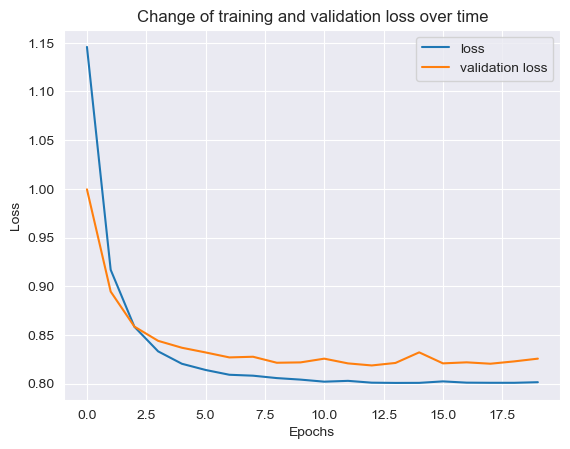

In [42]:
plot_loss(history)

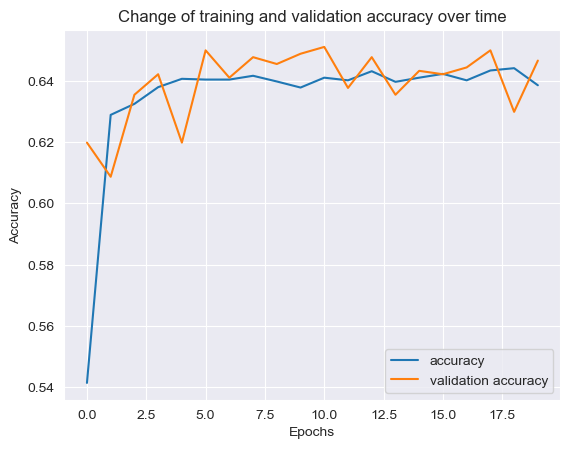

In [43]:
plot_accuracy(history)

# Deep model

In [44]:
model = Sequential()
model.add(Dense(32, input_shape=(7,), activation='relu'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(4, activation='softmax'))
model.compile(Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
history = model.fit(X_train[['GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7']], y_train, validation_split=0.1, epochs=20, verbose=0)
print_loss_and_accuracy(model, X_train[['GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7']], y_train, X_test[['GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7']], y_test)

Train:
281/281 [==============================] - 0s 560us/step - loss: 0.7837 - accuracy: 0.6501
Test:
121/121 [==============================] - 0s 625us/step - loss: 0.7808 - accuracy: 0.6536


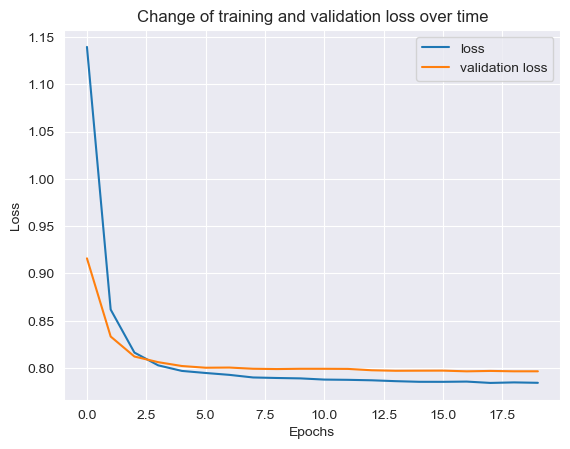

In [46]:
plot_loss(history)

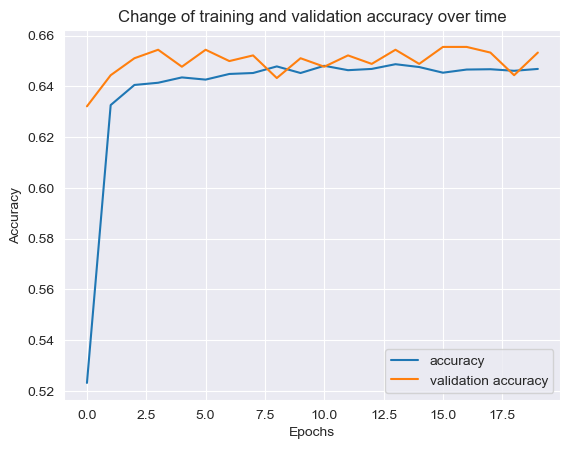

In [47]:
plot_accuracy(history)

# Test

In [48]:
model = Sequential()
model.add(Dense(32, input_shape=(9,), activation='tanh'))
# model.add(Dense(64, activation='sigmoid'))
model.add(Dense(4, activation='softmax'))
model.compile(Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
history = model.fit(X_train[['GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7', 'GAD_T', 'SWL_T']], y_train, validation_split=0.1, epochs=20, verbose=1)
print_loss_and_accuracy(model, X_train[['GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7', 'GAD_T', 'SWL_T']], y_train, X_test[['GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7', 'GAD_T', 'SWL_T']], y_test)

Epoch 1/20
253/253 [==============================] - 1s 1ms/step - loss: 1.0622 - accuracy: 0.4449 - val_loss: 0.9279 - val_accuracy: 0.5831
Epoch 2/20
253/253 [==============================] - 0s 742us/step - loss: 0.8815 - accuracy: 0.6070 - val_loss: 0.8692 - val_accuracy: 0.6020
Epoch 3/20
253/253 [==============================] - 0s 766us/step - loss: 0.8391 - accuracy: 0.6260 - val_loss: 0.8363 - val_accuracy: 0.6288
Epoch 4/20
253/253 [==============================] - 0s 718us/step - loss: 0.8135 - accuracy: 0.6381 - val_loss: 0.8182 - val_accuracy: 0.6355
Epoch 5/20
253/253 [==============================] - 0s 679us/step - loss: 0.8026 - accuracy: 0.6433 - val_loss: 0.8096 - val_accuracy: 0.6466
Epoch 6/20
253/253 [==============================] - 0s 680us/step - loss: 0.7960 - accuracy: 0.6466 - val_loss: 0.8026 - val_accuracy: 0.6488
Epoch 7/20
253/253 [==============================] - 0s 773us/step - loss: 0.7919 - accuracy: 0.6485 - val_loss: 0.7983 - val_accuracy: 0

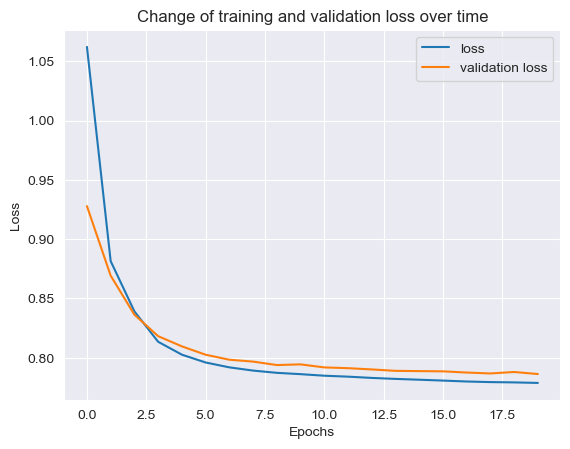

In [50]:
plot_loss(history)

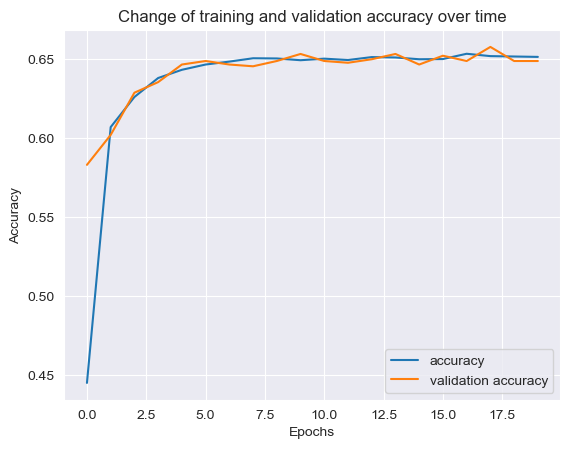

In [51]:
plot_accuracy(history)

# More testing

In [73]:
model = Sequential()
# model.add(BatchNormalization())
model.add(Dense(64, input_shape=(7,), activation='tanh'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(4, activation='softmax'))
model.compile(Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])

In [74]:
history = model.fit(X_train[['GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7']], y_train, validation_split=0.1, epochs=50, verbose=1)
print_loss_and_accuracy(model, X_train[['GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7']], y_train, X_test[['GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7']], y_test)

Epoch 1/50
253/253 [==============================] - 1s 1ms/step - loss: 1.0559 - accuracy: 0.5369 - val_loss: 0.9443 - val_accuracy: 0.6288
Epoch 2/50
253/253 [==============================] - 0s 873us/step - loss: 0.8909 - accuracy: 0.6343 - val_loss: 0.8594 - val_accuracy: 0.6377
Epoch 3/50
253/253 [==============================] - 0s 872us/step - loss: 0.8399 - accuracy: 0.6389 - val_loss: 0.8320 - val_accuracy: 0.6399
Epoch 4/50
253/253 [==============================] - 0s 1ms/step - loss: 0.8207 - accuracy: 0.6414 - val_loss: 0.8198 - val_accuracy: 0.6388
Epoch 5/50
253/253 [==============================] - 0s 1ms/step - loss: 0.8100 - accuracy: 0.6402 - val_loss: 0.8134 - val_accuracy: 0.6399
Epoch 6/50
253/253 [==============================] - 0s 943us/step - loss: 0.8030 - accuracy: 0.6408 - val_loss: 0.8082 - val_accuracy: 0.6466
Epoch 7/50
253/253 [==============================] - 0s 954us/step - loss: 0.7995 - accuracy: 0.6423 - val_loss: 0.8051 - val_accuracy: 0.641

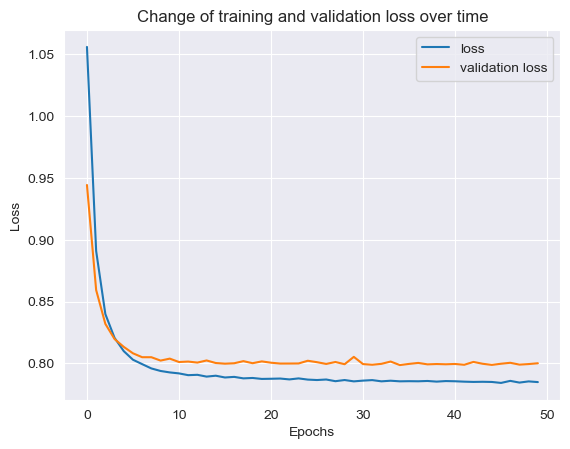

In [75]:
plot_loss(history)

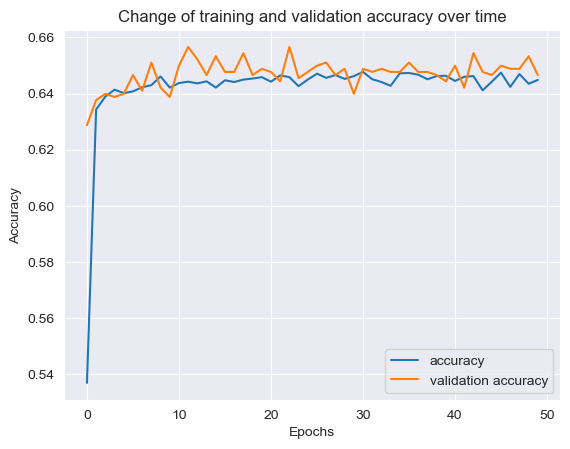

In [76]:
plot_accuracy(history)